In [1]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
# Load data
results_dirs = ['results', '.']
DATALIST = [json.loads(line.strip()) for results_dir in results_dirs for f_name in os.listdir(results_dir) if f_name.endswith('.jsonl') for line in open(os.path.join(results_dir, f_name)) if line.strip()]
len(DATALIST)

17184

In [3]:
# Assert that task_num and info.task_num are the same
assert all(d['task_num'] == d['info']['task_num'] for d in DATALIST)

# Assert that if tree_info is present, then tree_info has num_internal_nodes
assert all("num_internal_nodes" in d['tree_info'] for d in DATALIST if "tree_info" in d)

assert all(d['fastTreeGNE2']['reward'] == d['treeGNE2']['reward'] for d in DATALIST if 'fastTreeGNE2' in d and 'treeGNE2' in d)

assert all(d['OrNE']['reward'] == d['BnBOrNE']['reward'] for d in DATALIST if 'OrNE' in d and 'BnBOrNE' in d)

assert all(d['BnBOrNEskip']['reward'] == d['BnBOrNEskip']['reward'] for d in DATALIST if 'BnBOrNEskip' in d and 'BnBOrNE' in d)

In [4]:
# List of all algorithms
ALL_ALGORITHMS_COLORS = {
    'random_solution': 'grey',
    'treeGNE': 'green',
    'treeGNE2': 'purple',
    'fastTreeGNE2': 'blue',
    'simpleGNE': 'black',
    'AOsearchGNE': 'orange',
    'OrNE': 'magenta',
    'BnBOrNE': 'red',
    'BnBOrNEskip': 'yellow'
}
ALL_ALGORITHMS = [algorithm for algorithm in ALL_ALGORITHMS_COLORS.keys() if any(algorithm in d for d in DATALIST)]
ALGORITHMS = [algorithm for algorithm in ALL_ALGORITHMS if all(algorithm in d for d in DATALIST)]
ALGORITHMS

['random_solution', 'treeGNE', 'fastTreeGNE2', 'simpleGNE', 'BnBOrNE']

In [5]:
# Define the function to plot compare algorithms
def plot_compare_algorithms(ax : plt.Axes, x_value_f, y_value_f, xlabel, ylabel, title, algorithms=ALGORITHMS, algorithms_colors=ALL_ALGORITHMS_COLORS):
    y_values : dict[str, dict[str, list]] = { algorithm: {} for algorithm in algorithms }
    x_values_set = set()
    for d in DATALIST:
        found_invalid_data_point = False
        for algorithm in algorithms:
            try:
                x_value = x_value_f(d, algorithm)
                y_value = y_value_f(d, algorithm)
            except:
                found_invalid_data_point = True
                break
        if found_invalid_data_point:
            continue
        for algorithm in algorithms:
            x_value = x_value_f(d, algorithm)
            y_value = y_value_f(d, algorithm)
            x_values_set.add(x_value)
            y_values[algorithm][x_value] = y_values[algorithm].get(x_value, [])
            y_values[algorithm][x_value].append(y_value)

    for algorithm in algorithms:
        y_values[algorithm] = {x_value: np.mean(y_values[algorithm][x_value]) for x_value in sorted(y_values[algorithm].keys())}    
        ax.plot(list(y_values[algorithm].keys()), list(y_values[algorithm].values()), label=algorithm, color=algorithms_colors[algorithm], marker='o')

    ax.set_title(title)
    
    x_values_set = list(x_values_set)
    min_x_value = min(sorted(x_values_set))
    max_x_value = max(sorted(x_values_set))
    # X axis have 10 ticks plus the first and last. All ticks must be in the x_values_set
    # plt.xlabel(xlabel)
    # plt.ylabel(ylabel)
    # plt.show()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax

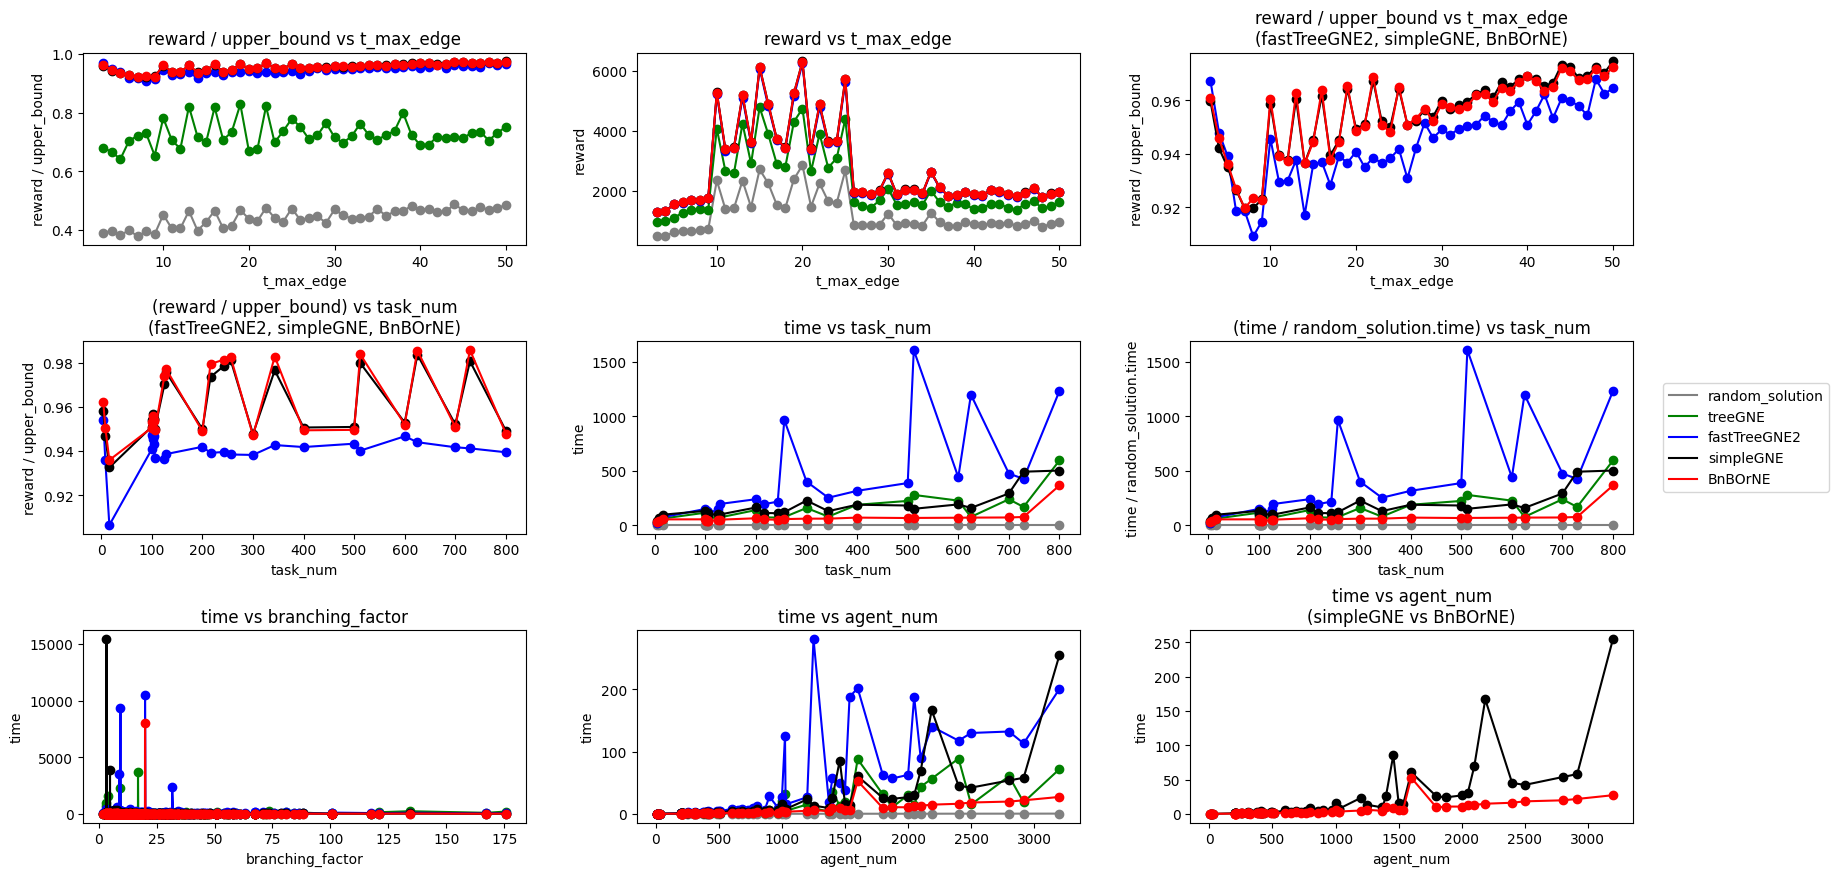

In [6]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
axs[0, 0] = plot_compare_algorithms(
    axs[0, 0],
    x_value_f=lambda d, algorithm: d['info']['t_max_edge'],
    y_value_f=lambda d, algorithm: d[algorithm]['reward'] / d['upper_bound'],
    xlabel='t_max_edge',
    ylabel='reward / upper_bound',
    title='reward / upper_bound vs t_max_edge'
)
axs[0, 1] = plot_compare_algorithms(
    axs[0, 1],
    x_value_f=lambda d, algorithm: d['info']['t_max_edge'],
    y_value_f=lambda d, algorithm: d[algorithm]['reward'],
    xlabel='t_max_edge',
    ylabel='reward',
    title='reward vs t_max_edge'
)
axs[0, 2] = plot_compare_algorithms(
    axs[0, 2],
    x_value_f=lambda d, algorithm: d['info']['t_max_edge'],
    y_value_f=lambda d, algorithm: d[algorithm]['reward'] / d['upper_bound'],
    xlabel='t_max_edge',
    ylabel='reward / upper_bound',
    title='reward / upper_bound vs t_max_edge\n(fastTreeGNE2, simpleGNE, BnBOrNE)',
    algorithms=['fastTreeGNE2', 'simpleGNE', 'BnBOrNE']
)
axs[1, 0] = plot_compare_algorithms(
    axs[1, 0],
    x_value_f=lambda d, algorithm: d['info']['task_num'],
    y_value_f=lambda d, algorithm: d[algorithm]['reward'] / d['upper_bound'],
    xlabel='task_num',
    ylabel='reward / upper_bound',
    title='(reward / upper_bound) vs task_num\n(fastTreeGNE2, simpleGNE, BnBOrNE)',
    algorithms=['fastTreeGNE2', 'simpleGNE', 'BnBOrNE']
)
axs[1, 1] = plot_compare_algorithms(
    ax=axs[1, 1],
    x_value_f=lambda d, algorithm: d['info']['task_num'],
    y_value_f=lambda d, algorithm: d[algorithm]['time'] / d['random_solution']['time'],
    xlabel='task_num',
    ylabel='time',
    title='time vs task_num'
)
axs[1, 2] = plot_compare_algorithms(
    ax=axs[1, 2],
    x_value_f=lambda d, algorithm: d['info']['task_num'],
    y_value_f=lambda d, algorithm: d[algorithm]['time'] / d['random_solution']['time'],
    xlabel='task_num',
    ylabel='time / random_solution.time',
    title='(time / random_solution.time) vs task_num'
)
axs[2, 0] = plot_compare_algorithms(
    ax=axs[2, 0],
    x_value_f=lambda d, algorithm: d['tree_info']['branching_factor'],
    y_value_f=lambda d, algorithm: d[algorithm]['time'],
    xlabel='branching_factor',
    ylabel='time',
    title='time vs branching_factor'
)
axs[2, 1] = plot_compare_algorithms(
    ax=axs[2, 1],
    x_value_f=lambda d, algorithm: d['info']['agent_num'],
    y_value_f=lambda d, algorithm: d[algorithm]['time'],
    xlabel='agent_num',
    ylabel='time',
    title='time vs agent_num'
)
axs[2, 2] = plot_compare_algorithms(
    ax=axs[2, 2],
    x_value_f=lambda d, algorithm: d['info']['agent_num'],
    y_value_f=lambda d, algorithm: d[algorithm]['time'],
    xlabel='agent_num',
    ylabel='time',
    title='time vs agent_num\n(simpleGNE vs BnBOrNE)',
    algorithms=['simpleGNE', 'BnBOrNE']
)

# Add bottom margin to each subplot
fig.subplots_adjust(hspace=0.5, wspace=0.25)

# Create a global legend for all subplots based on ALL_ALGORITHMS_COLORS
fig.legend(handles=[plt.Line2D([0], [0], color=ALL_ALGORITHMS_COLORS[algorithm], label=algorithm) for algorithm in ALGORITHMS], loc='right')

Text(0.5, 1.0, 'BnBOrNE time vs num_nodes')

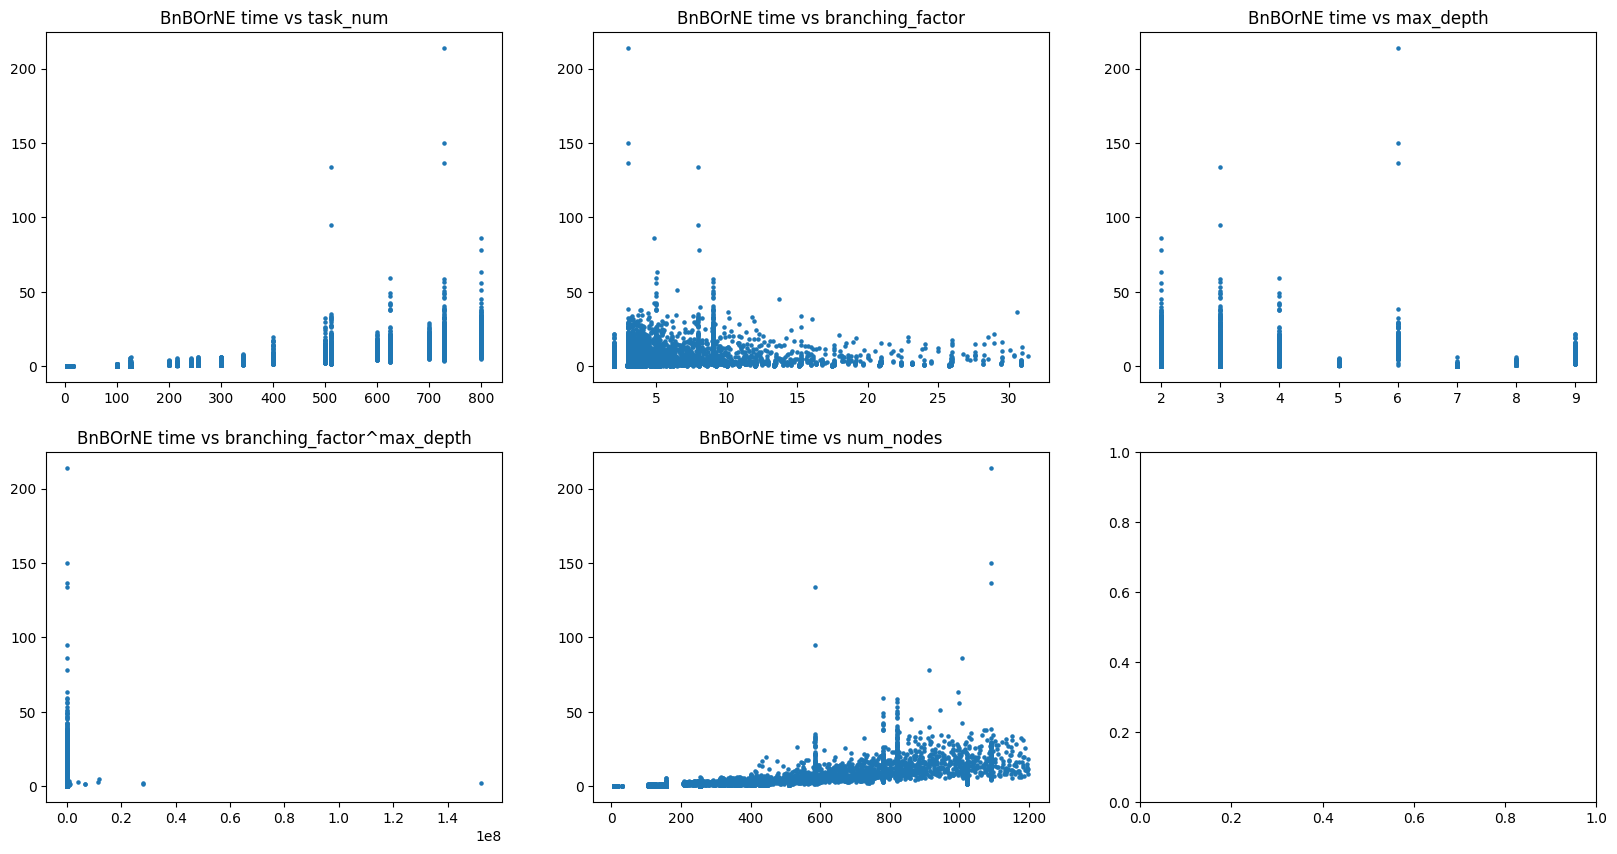

In [7]:
# BnBOrNE evaluation
x_task_num = [d['task_num'] for d in DATALIST if 'tree_info' in d]
x_branching_factor = [d['tree_info']['branching_factor'] for d in DATALIST if 'tree_info' in d]
x_max_depth = [d['tree_info']['max_depth'] for d in DATALIST if 'tree_info' in d]
x_b_d = [d['tree_info']['branching_factor']**d['tree_info']['max_depth'] for d in DATALIST if 'tree_info' in d]
x_num_nodes = [(d['tree_info']['num_internal_nodes'] + d['info']['task_num']) for d in DATALIST if 'tree_info' in d]
y = [d['BnBOrNE']['time'] for d in DATALIST if 'tree_info' in d]
x_task_num = np.array(x_task_num)
x_branching_factor = np.array(x_branching_factor)
x_max_depth = np.array(x_max_depth)
x_b_d = np.array(x_b_d)
x_num_nodes = np.array(x_num_nodes)
y = np.array(y)
# mask = np.abs(stats.zscore(y)) < 3 and np.abs(stats.zscore(x)) < 3
zy = np.abs(stats.zscore(y))
zx = np.abs(stats.zscore(x_b_d))
zx_task_num = np.abs(stats.zscore(x_task_num))
zx_branching_factor = np.abs(stats.zscore(x_branching_factor))
zx_max_depth = np.abs(stats.zscore(x_max_depth))
zx_num_nodes = np.abs(stats.zscore(x_num_nodes))
mask = (zy < 2) & (zx < 3) & (zx_task_num < 3) & (zx_branching_factor < 3) & (zx_max_depth < 3)
x_b_d = x_b_d[mask]
y = y[mask]
x_task_num = x_task_num[mask]
x_branching_factor = x_branching_factor[mask]
x_max_depth = x_max_depth[mask]
x_num_nodes = x_num_nodes[mask]

# Create multiple subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
# fig.suptitle('Vertically stacked subplots')
axs[0, 0].scatter(x_task_num, y, s=5)
axs[0, 0].set_title('BnBOrNE time vs task_num')
axs[0, 1].scatter(x_branching_factor, y, s=5)
axs[0, 1].set_title('BnBOrNE time vs branching_factor')
axs[0, 2].scatter(x_max_depth, y, s=5)
axs[0, 2].set_title('BnBOrNE time vs max_depth')
axs[1, 0].scatter(x_b_d, y, s=5)
axs[1, 0].set_title('BnBOrNE time vs branching_factor^max_depth')
axs[1, 1].scatter(x_num_nodes, y, s=5)
axs[1, 1].set_title('BnBOrNE time vs num_nodes')
# plt.scatter(x, y, label='BnBOrNE time vs branching_factor^max_depth', s=5)

Text(0.5, 1.0, 'fastTreeGNE2 time vs num_nodes')

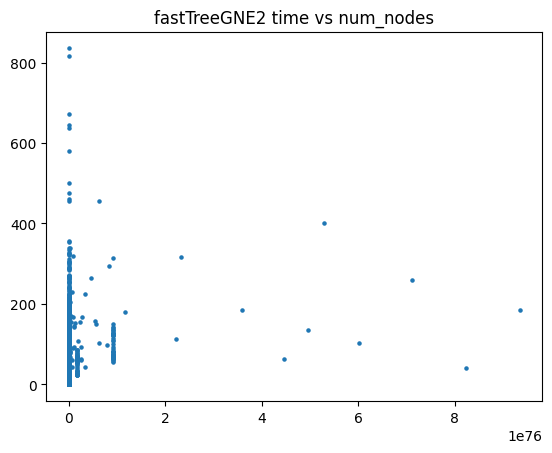

In [8]:
x = [(d['tree_info']['num_internal_nodes'] + d['info']['task_num']) ** (d['info']['t_max_edge']) for d in DATALIST if 'tree_info' in d]
y = [d['fastTreeGNE2']['time'] for d in DATALIST if 'tree_info' in d]
x = np.array(x)
y = np.array(y)
stdx = np.std(x)
meanx = np.mean(x)
zx = [abs(x[i] - meanx) / stdx for i in range(len(x))]
zy = stats.zscore(y)
mask = (zy < 1.6)
x = np.array(x)
y = np.array(y)
y = y[mask]
x = x[mask]
plt.scatter(x, y, s=5)
plt.title('fastTreeGNE2 time vs num_nodes')


C:\Users\An\AppData\Local\Temp\ipykernel_15224\3130236887.py:66: RuntimeWarning: invalid value encountered in divide
  cax = ax.matshow(comparison_matrix[:, :, 2]  /comparison_matrix[:, :, 5], cmap='coolwarm')
C:\Users\An\AppData\Local\Temp\ipykernel_15224\3130236887.py:89: RuntimeWarning: invalid value encountered in scalar divide
  higher_percentage = comparison_matrix[i, j, 2]/comparison_matrix[i, j, 5] * 100
C:\Users\An\AppData\Local\Temp\ipykernel_15224\3130236887.py:90: RuntimeWarning: invalid value encountered in scalar divide
  lower_percentage = comparison_matrix[i, j, 4]/comparison_matrix[i, j, 5] * 100
C:\Users\An\AppData\Local\Temp\ipykernel_15224\3130236887.py:91: RuntimeWarning: invalid value encountered in scalar divide
  equal_percentage = comparison_matrix[i, j, 3]/comparison_matrix[i, j, 5] * 100
C:\Users\An\AppData\Local\Temp\ipykernel_15224\3130236887.py:66: RuntimeWarning: invalid value encountered in divide
  cax = ax.matshow(comparison_matrix[:, :, 2]  /compariso

Text(0.5, 1.0, 'time')

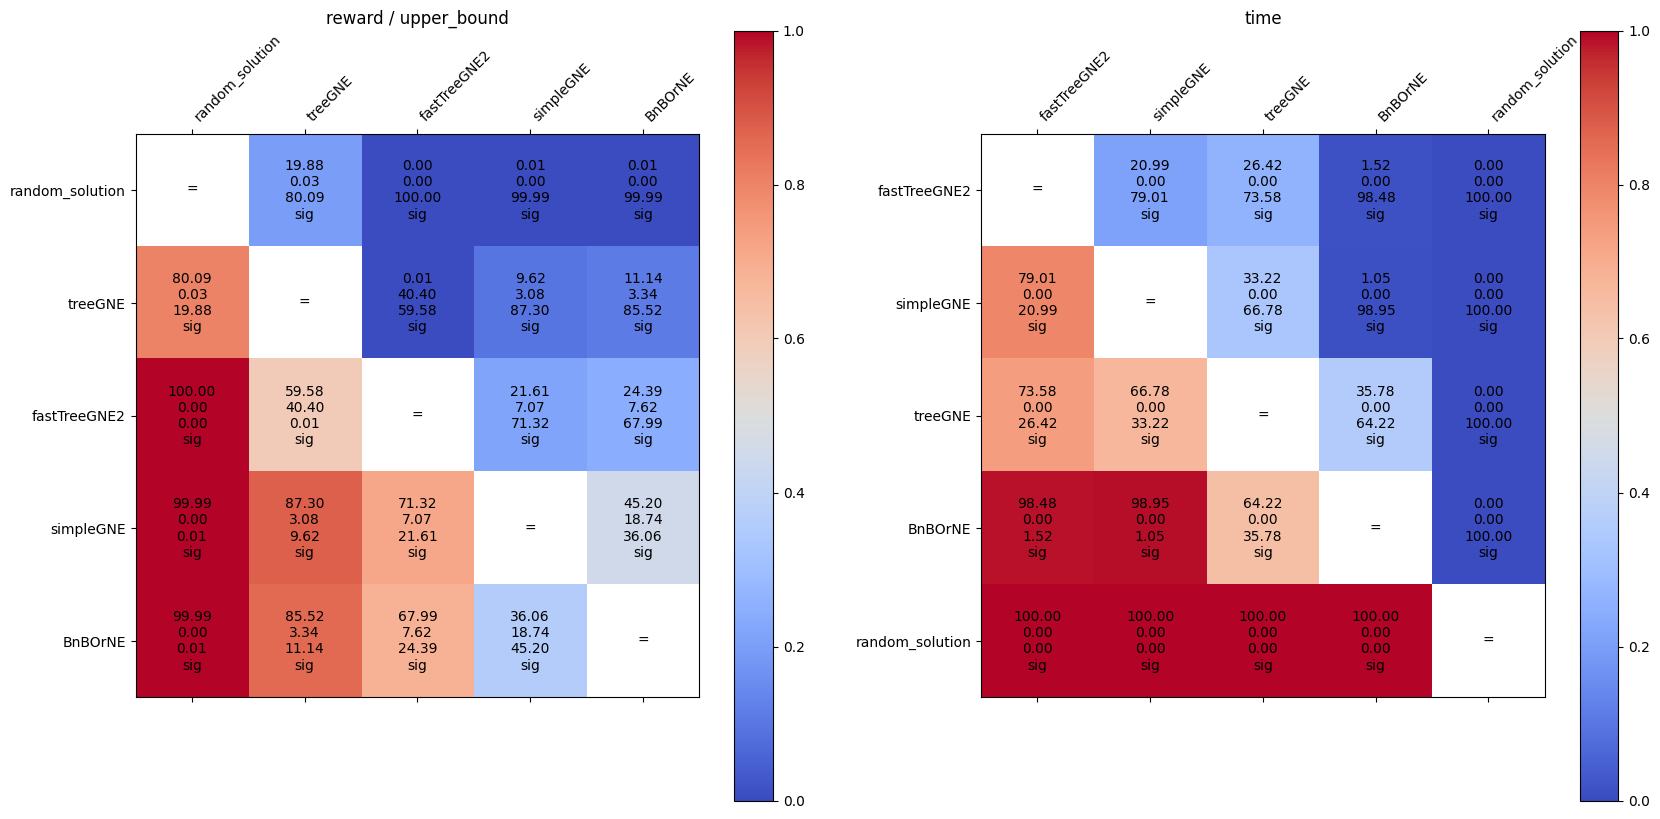

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from scipy.stats import wilcoxon

# Wilcoxon signed-rank test

def compare_two_algorithms(algorithm1, algorithm2, value_f, check_is_higher=True):

    data = [(value_f(d, algorithm1), value_f(d, algorithm2)) for d in DATALIST if algorithm1 in d and algorithm2 in d]
    count = len(data)
    diff_higher = len([x for x in data if x[0] > x[1]])
    count_equal = len([x for x in data if x[0] == x[1]])
    diff_lower = len([x for x in data if x[0] < x[1]])

    # alternative = 'greater' if check_is_higher else 'less'
    alternative = 'two-sided' 

    # Perform Wilcoxon signed-rank test
    statistic, p_value = wilcoxon([x[0] for x in data], [x[1] for x in data], alternative=alternative)

    diff_strict = diff_higher if check_is_higher else diff_lower
    diff_reverse = diff_lower if check_is_higher else diff_higher

    return p_value, statistic, diff_strict, count_equal, diff_reverse, count
    
    # # Interpret the results
    # alpha = 0.05
    # if p_value < alpha:
    #     if higher_percentage > 0.5:
    #         print("There is a significant difference between the first and second elements. The first element is higher (p-value=%f)." % p_value)
    #         print(p_value == 0, statistic, higher_percentage)
    #     else:
    #         print("There is a significant difference between the first and second elements. The second element is higher (p-value=%f)." % p_value)
    # else:
    #     print("There is no significant difference between the first and second elements.")

# Create comparison matrix

def create_comparison_matrix(algorithms, value_f, check_is_higher=True):
    algorithms_sorted = sorted(algorithms, key=lambda x: np.average([value_f(d, x) for d in DATALIST if x in d]), reverse=(not check_is_higher))

    comparison_matrix = np.zeros((len(algorithms_sorted), len(algorithms_sorted), 6))

    for i, algorithm1 in enumerate(algorithms_sorted):
        for j, algorithm2 in enumerate(algorithms_sorted):
            if i == j:
                continue
            p_value, statistic, diff_strict, count_equal, diff_reverse, count = compare_two_algorithms(algorithm1, algorithm2, value_f, check_is_higher=check_is_higher)
            comparison_matrix[i, j, 0] = p_value
            comparison_matrix[i, j, 1] = statistic
            comparison_matrix[i, j, 2] = diff_strict
            comparison_matrix[i, j, 3] = count_equal
            comparison_matrix[i, j, 4] = diff_reverse
            comparison_matrix[j, i, 5] = count

    return comparison_matrix, algorithms_sorted

def draw_comparison_matrix(fig : plt.Figure, ax : plt.Axes, algorithms, value_f, check_is_higher = True):

    comparison_matrix, algorithms_sorted = create_comparison_matrix(algorithms=algorithms, value_f=value_f, check_is_higher=check_is_higher)
    # Draw comparison matrix, where color is based on whether p-value < 0.05 or not, value is based on difference percentage
    # fig, ax = plt.subplots()
    # Color only applies if row != column
    cax = ax.matshow(comparison_matrix[:, :, 2]  /comparison_matrix[:, :, 5], cmap='coolwarm')
    cax.set_clim(0, 1)
    # Add color bar
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(algorithms_sorted)))
    ax.set_yticks(np.arange(len(algorithms_sorted)))
    ax.set_xticklabels(algorithms_sorted, rotation=45, ha="left")
    ax.set_yticklabels(algorithms_sorted)


    # Rotate the tick labels and set their alignment.
    # fig.autofmt_xdate()
    # Rotate the tick labels and set their alignment.
    # plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    # fig.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")



    # Loop over data dimensions and create text annotations.
    for i in range(len(algorithms_sorted)):
        for j in range(len(algorithms_sorted)):
            higher_percentage = comparison_matrix[i, j, 2]/comparison_matrix[i, j, 5] * 100
            lower_percentage = comparison_matrix[i, j, 4]/comparison_matrix[i, j, 5] * 100
            equal_percentage = comparison_matrix[i, j, 3]/comparison_matrix[i, j, 5] * 100
            p_value = comparison_matrix[i, j, 0] < 0.05
            text_str = f'{higher_percentage:.2f}\n{equal_percentage:.2f}\n{lower_percentage:.2f}\n{"sig" if p_value else "n.s."}'
            if i == j:
                text_str = '='
            text = ax.text(j, i, text_str,ha="center", va="center", color="black" if p_value else "white")
            
    return fig, ax


fig, axs = plt.subplots(1, 2, figsize=(20, 10))
fig, axs[0] = draw_comparison_matrix(fig, axs[0], ALGORITHMS, lambda d, algorithm: d[algorithm]['reward'] / d['upper_bound'], check_is_higher=True)
axs[0].set_title('reward / upper_bound')
fig, axs[1] = draw_comparison_matrix(fig, axs[1], ALGORITHMS, lambda d, algorithm: d[algorithm]['time'], check_is_higher=False)
axs[1].set_title('time')

In [10]:
{
    "task_num": 128,
    "tree_info": {
        "max_depth": 7,
        "min_depth": 7,
        "branching_factor": 2.0,
        "min_degree": 2,
        "max_degree": 2,
        "num_internal_nodes": 127,
    },
    "upper_bound": 592,
    "random_solution": {"reward": 292, "time": 0.013374300033319741},
    "treeGNE": {
        "reward": 577,
        "time": 0.6030290999915451,
        "iteration": 41,
        "re-assignment": 0,
    },
    "fastTreeGNE2": {
        "reward": 577,
        "time": 3.304753799980972,
        "iteration": 271,
        "re-assignment": 19,
    },
    "simpleGNE": {
        "reward": 564,
        "time": 1.9341076000127941,
        "iteration_1": 758,
        "re-assignment_1": 91,
        "iteration_2": 67,
        "re-assignment_2": 1,
        "loop": 3,
    },
    "BnBOrNE": {
        "reward": 577,
        "time": 1.294037899991963,
        "iteration": 561,
        "re-assignment": 35,
    },
    "info": {
        "ex_identifier": 2,
        "task_num": 128,
        "agent_num": 256,
        "capNum": 10,
        "up": 6196,
        "up2": 6191,
        "a_den_avg": 4.99609375,
        "a_den_max": 10,
        "a_den_min": 1,
        "t_den_avg": 9.9921875,
        "t_den_max": 10,
        "t_den_min": 9,
        "t_max_edge": 10,
        "g": 5311,
        "g_iter": 271,
        "g_reass": 20,
        "g_t": 0.9035366999451071,
    },
}

{'task_num': 128,
 'tree_info': {'max_depth': 7,
  'min_depth': 7,
  'branching_factor': 2.0,
  'min_degree': 2,
  'max_degree': 2,
  'num_internal_nodes': 127},
 'upper_bound': 592,
 'random_solution': {'reward': 292, 'time': 0.013374300033319741},
 'treeGNE': {'reward': 577,
  'time': 0.6030290999915451,
  'iteration': 41,
  're-assignment': 0},
 'fastTreeGNE2': {'reward': 577,
  'time': 3.304753799980972,
  'iteration': 271,
  're-assignment': 19},
 'simpleGNE': {'reward': 564,
  'time': 1.9341076000127941,
  'iteration_1': 758,
  're-assignment_1': 91,
  'iteration_2': 67,
  're-assignment_2': 1,
  'loop': 3},
 'BnBOrNE': {'reward': 577,
  'time': 1.294037899991963,
  'iteration': 561,
  're-assignment': 35},
 'info': {'ex_identifier': 2,
  'task_num': 128,
  'agent_num': 256,
  'capNum': 10,
  'up': 6196,
  'up2': 6191,
  'a_den_avg': 4.99609375,
  'a_den_max': 10,
  'a_den_min': 1,
  't_den_avg': 9.9921875,
  't_den_max': 10,
  't_den_min': 9,
  't_max_edge': 10,
  'g': 5311,
  '

In [11]:
{
    "task_num": 500,
    "tree_info": {
        "max_depth": 2,
        "min_depth": 2,
        "branching_factor": 3.376190476190476,
        "min_degree": 2,
        "max_degree": 209,
        "num_internal_nodes": 210,
    },
    "upper_bound": 24864,
    "random_solution": {"reward": 7802, "time": 0.11868389998562634},
    "treeGNE": {
        "reward": 23179,
        "time": 48.779179799952544,
        "iteration": 1139,
        "re-assignment": 73,
    },
    "treeGNE2": {
        "reward": 23301,
        "time": 103.63403219997417,
        "iteration": 1971,
        "re-assignment": 179,
    },
    "fastTreeGNE2": {
        "reward": 23301,
        "time": 36.41690469998866,
        "iteration": 1971,
        "re-assignment": 179,
    },
    "simpleGNE": {
        "reward": 23393,
        "time": 25.214789899997413,
        "iteration_1": 4721,
        "re-assignment_1": 1183,
        "iteration_2": 1257,
        "re-assignment_2": 130,
        "loop": 4,
    },
    "AOsearchGNE": {
        "reward": 19172,
        "time": 133.24300409993157,
        "iteration": 2199,
        "re-assignment": 231,
        "loop": 2,
    },
    "OrNE": {
        "reward": 23345,
        "time": 9.26101519993972,
        "iteration": 2444,
        "re-assignment": 199,
    },
    "BnBOrNE": {
        "reward": 23345,
        "time": 10.071934700012207,
        "iteration": 2444,
        "re-assignment": 199,
    },
    "BnBOrNEskip": {
        "reward": 23345,
        "time": 9.812757199979387,
        "iteration": 2444,
        "re-assignment": 199,
    },
    "info": {
        "ex_identifier": 781,
        "task_num": 500,
        "agent_num": 2000,
        "capNum": 13,
        "up": 45945,
        "up2": 45759,
        "a_den_avg": 3.9995,
        "a_den_max": 16,
        "a_den_min": 1,
        "t_den_avg": 15.998,
        "t_den_max": 16,
        "t_den_min": 15,
        "t_max_edge": 16,
        "g": 41908,
        "g_iter": 1873,
        "g_reass": 142,
        "g_t": 30.781984800007194,
    },
}

{'task_num': 500,
 'tree_info': {'max_depth': 2,
  'min_depth': 2,
  'branching_factor': 3.376190476190476,
  'min_degree': 2,
  'max_degree': 209,
  'num_internal_nodes': 210},
 'upper_bound': 24864,
 'random_solution': {'reward': 7802, 'time': 0.11868389998562634},
 'treeGNE': {'reward': 23179,
  'time': 48.779179799952544,
  'iteration': 1139,
  're-assignment': 73},
 'treeGNE2': {'reward': 23301,
  'time': 103.63403219997417,
  'iteration': 1971,
  're-assignment': 179},
 'fastTreeGNE2': {'reward': 23301,
  'time': 36.41690469998866,
  'iteration': 1971,
  're-assignment': 179},
 'simpleGNE': {'reward': 23393,
  'time': 25.214789899997413,
  'iteration_1': 4721,
  're-assignment_1': 1183,
  'iteration_2': 1257,
  're-assignment_2': 130,
  'loop': 4},
 'AOsearchGNE': {'reward': 19172,
  'time': 133.24300409993157,
  'iteration': 2199,
  're-assignment': 231,
  'loop': 2},
 'OrNE': {'reward': 23345,
  'time': 9.26101519993972,
  'iteration': 2444,
  're-assignment': 199},
 'BnBOrNE':

In [12]:
{
    "task_num": 100,
    "upper_bound": 1605,
    "random_solution": {"reward": 486, "time": 0.003914499975508079},
    "treeGNE": {
        "reward": 1519,
        "time": 0.1602038000128232,
        "iteration": 96,
        "re-assignment": 2,
    },
    "treeGNE2": {
        "reward": 1519,
        "time": 0.38037139998050407,
        "iteration": 208,
        "re-assignment": 8,
    },
    "fastTreeGNE2": {
        "reward": 1519,
        "time": 0.2184568999800831,
        "iteration": 208,
        "re-assignment": 8,
    },
    "simpleGNE": {
        "reward": 1519,
        "time": 0.14501409998047166,
        "iteration_1": 345,
        "re-assignment_1": 55,
        "iteration_2": 105,
        "re-assignment_2": 8,
        "loop": 2,
    },
    "AOsearchGNE": {
        "reward": 1247,
        "time": 0.7515272999880835,
        "iteration": 246,
        "re-assignment": 23,
        "loop": 2,
    },
    "OrNE": {
        "reward": 1523,
        "time": 0.09179649999714456,
        "iteration": 280,
        "re-assignment": 13,
    },
    "BnBOrNE": {
        "reward": 1523,
        "time": 0.09189929999411106,
        "iteration": 280,
        "re-assignment": 13,
    },
    "BnBOrNEskip": {
        "reward": 1523,
        "time": 0.0931538000004366,
        "iteration": 280,
        "re-assignment": 13,
    },
    "info": {
        "ex_identifier": 1,
        "task_num": 100,
        "agent_num": 200,
        "capNum": 10,
        "up": 4913,
        "up2": 4903,
        "a_den_avg": 4.995,
        "a_den_max": 10,
        "a_den_min": 1,
        "t_den_avg": 9.99,
        "t_den_max": 10,
        "t_den_min": 9,
        "t_max_edge": 10,
        "g": 4151,
        "g_iter": 201,
        "g_reass": 7,
        "g_t": 0.19358550000470132,
    },
}

{'task_num': 100,
 'upper_bound': 1605,
 'random_solution': {'reward': 486, 'time': 0.003914499975508079},
 'treeGNE': {'reward': 1519,
  'time': 0.1602038000128232,
  'iteration': 96,
  're-assignment': 2},
 'treeGNE2': {'reward': 1519,
  'time': 0.38037139998050407,
  'iteration': 208,
  're-assignment': 8},
 'fastTreeGNE2': {'reward': 1519,
  'time': 0.2184568999800831,
  'iteration': 208,
  're-assignment': 8},
 'simpleGNE': {'reward': 1519,
  'time': 0.14501409998047166,
  'iteration_1': 345,
  're-assignment_1': 55,
  'iteration_2': 105,
  're-assignment_2': 8,
  'loop': 2},
 'AOsearchGNE': {'reward': 1247,
  'time': 0.7515272999880835,
  'iteration': 246,
  're-assignment': 23,
  'loop': 2},
 'OrNE': {'reward': 1523,
  'time': 0.09179649999714456,
  'iteration': 280,
  're-assignment': 13},
 'BnBOrNE': {'reward': 1523,
  'time': 0.09189929999411106,
  'iteration': 280,
  're-assignment': 13},
 'BnBOrNEskip': {'reward': 1523,
  'time': 0.0931538000004366,
  'iteration': 280,
  'r